<a href="https://colab.research.google.com/github/Icrz11/CS114.K21/blob/master/Sacrasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khangnguyenhuu","key":"48f6620ba815aa2812de52477b147c80"}'}

In [2]:
!pip install kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 54.1MB/s]


In [0]:
#extract sarcasm zip file
from zipfile import ZipFile
zf = ZipFile("/content/news-headlines-dataset-for-sarcasm-detection.zip")
zf.extractall()

In [3]:
#read data
import pandas as pd
df = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines = True)
df.head()
df = df.drop(['article_link'], axis = 1)
print (df)

                                                headline  is_sarcastic
0      former versace store clerk sues over secret 'b...             0
1      the 'roseanne' revival catches up to our thorn...             0
2      mom starting to fear son's web series closest ...             1
3      boehner just wants wife to listen, not come up...             1
4      j.k. rowling wishes snape happy birthday in th...             0
...                                                  ...           ...
26704               american politics in moral free-fall             0
26705                            america's best 20 hikes             0
26706                              reparations and obama             0
26707  israeli ban targeting boycott supporters raise...             0
26708                  gourmet gifts for the foodie 2014             0

[26709 rows x 2 columns]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
import string 
from string import digits
from string import punctuation


for i in df['headline']:
  i = str(i)

    

In [6]:
#clean the data remove all digits and punctuation
hl_clean = []
for i in df['headline']:
  clean = i.translate(str.maketrans('', '', punctuation))
  clean = clean.translate(str.maketrans('', '', digits))
  hl_clean.append(clean)

print('Before: ')
print(df['headline'][37])
print ('After: ')
print (hl_clean[37])


Before: 
'moana' sails straight to the top of the box office with massive $81.1 million opening
After: 
moana sails straight to the top of the box office with massive  million opening


In [7]:
#tokenization, break the headline to the lonely character like noun, pharse, ....
hl_tokens = []
for i in hl_clean:
  i = i.split()
  hl_tokens.append(i)

print ('before: ')
print (hl_clean[100])
print ('after: ')
print (hl_tokens[100])

before: 
demi lovato drops emotional nightingale music vid
after: 
['demi', 'lovato', 'drops', 'emotional', 'nightingale', 'music', 'vid']


In [75]:

#Use Bag of words
import nltk
nltk.download('punkt')
wordfreq = {}
#Build a dictionary to save how many time the word appear
for i in hl_tokens:
  for j in i:
    if (j not in wordfreq.keys()):
      wordfreq[j] = 1
    else:
      wordfreq[j] += 1
  
print (len (wordfreq))




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
27653


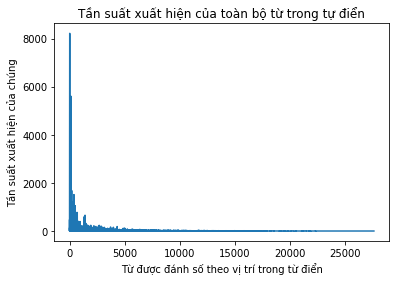

In [79]:
import matplotlib.pyplot as plt
import numpy as np
a = wordfreq.values()
a = list(a)
a = np.array(a)
plt.plot(a)
plt.title("Tần suất xuất hiện của toàn bộ từ trong tự điển")
plt.xlabel("Từ được đánh số theo vị trí trong từ điển")
plt.ylabel("Tần suất xuất hiện của chúng")
plt.show()

In [9]:
#build an array to save words most appear in wordfreq
import heapq
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)
print (most_freq)

['to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with', 'is', 'new', 'trump', 'man', 'from', 'at', 'about', 'you', 'this', 'by', 'after', 'be', 'how', 'out', 'it', 'that', 'as', 'up', 'not', 'are', 'your', 'what', 'his', 'he', 'just', 'who', 'us', 'has', 'will', 'more', 'all', 'into', 'report', 'one', 'why', 'have', 'area', 'over', 'donald', 'says', 'day', 'woman', 'can', 'its', 'time', 'no', 'first', 'like', 'get', 'her', 'trumps', 'people', 'an', 'i', 'now', 'obama', 'house', 'off', 'life', 'make', 'still', 'women', 'was', 'than', 'my', 'white', 'we', 'back', 'clinton', 'down', 'if', 'when', 'world', 'years', 'could', 'family', 'their', 'do', 'before', 'americans', 'most', 'way', 'black', 'they', 'gop', 'study', 'year', 'bill', 'yearold', 'should', 'would', 'so', 'him', 'best', 'police', 'only', 'watch', 'really', 'but', 'american', 'being', 'show', 'school', 'cant', 'know', 'things', 'good', 'home', 'during', 'death', 'president', 'finds', 'say', 'video', 'nation', 'going', 'love

In [0]:
#bag of word
array = []
count = 0
for i in hl_tokens:
  tmp = []
  for j in most_freq:
    if (j in i):
      tmp.append(1)
    else:
      tmp.append(0)
  array.append(tmp)




In [32]:
X = array
Y = df['is_sarcastic']
print (len(X))
print (len(Y))

X_train, X_test , Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
print (len(X_train))
print (len (Y_train))


26709
26709
18696
18696


In [66]:
from sklearn.naive_bayes import GaussianNB
clf1 = GaussianNB()
clf.fit(X_train, Y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [67]:
Y_pred = clf.predict(X_test)
print ("Accurancy score: ", accuracy_score(Y_test, Y_pred))

Accurancy score:  0.7742418569824036
